In [73]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages

In [74]:
df = pd.read_csv('alarm_data.csv', delimiter=";")

In [75]:
# or df = db.get_alerts()

In [ ]:
"""
Given the structure of our database, because of mapping and the use of json columns,
alarm information can be loaded into the database in its original format
(directly from the file alarm_data.csv) without any modifications.

In such case, all modifications to this table's information that are performed below
will be performed with a subset of the alarm information from the database "alerts" table
for the period we require (2022.02.24 - 2025.03.01)

This structure allows us to keep the information in the database in its original format
(in which it comes to us), regardless of its source (historical information or received from api).
And its processing will be performed after it is received from the database

For simplicity of the example and better clarity of the analysis, we will work
with the file with historical information “as it is”
"""

In [76]:
df

,id,region_id,region_city,all_region,start,end
0,52432,12,Львівська обл.,1,2022-02-24 07:43:17,2022-02-24 09:52:28
1,53292,23,Чернігівська обл.,1,2022-02-24 14:00:43,2022-02-24 17:11:43
2,52080,3,Вінницька обл.,1,2022-02-24 15:40:42,2022-02-24 16:10:42
3,52857,19,Харківська обл.,1,2022-02-24 20:11:47,2022-02-24 20:59:47
4,52700,18,Тернопільська обл.,1,2022-02-25 01:59:36,2022-02-25 09:00:19
...,...,...,...,...,...,...
55783,158642,14,Одеська обл.,1,2025-03-01 21:49:30,2025-03-01 23:24:45
55784,158635,9,Київська обл.,1,2025-03-01 22:20:51,2025-03-02 01:38:57
55785,158636,9,Київ,0,2025-03-01 22:52:10,2025-03-02 00:55:18
55786,158617,3,Вінницька обл.,1,2025-03-01 23:26:07,2025-03-02 02:44:07


In [77]:
# 1. BASIC PREPARATION

In [78]:
# eliminating duplication in the keys and skipping the region with low number of records (Crimea)

df.groupby(['region_id','region_city']).size().reset_index()

,region_id,region_city,0
0,1,Чернівецька обл.,665
1,2,Волинська обл.,757
2,3,Вінницька обл.,1373
3,4,Дніпропетровська обл.,4966
4,5,Донецька обл.,5886
5,6,Житомирська обл.,1334
6,7,Закарпатська обл.,581
7,8,Запорізька обл.,5494
8,9,Київ,1552
9,9,Київська обл.,1654


In [79]:
df.loc[df["region_city"] == "Київ", "region_id"] = 25

In [80]:
df = df[df['region_city'] != 'Крим']

In [81]:
df.groupby(['region_id','region_city']).size().reset_index()

,region_id,region_city,0
0,1,Чернівецька обл.,665
1,2,Волинська обл.,757
2,3,Вінницька обл.,1373
3,4,Дніпропетровська обл.,4966
4,5,Донецька обл.,5886
5,6,Житомирська обл.,1334
6,7,Закарпатська обл.,581
7,8,Запорізька обл.,5494
8,9,Київська обл.,1654
9,10,Кіровоградська обл.,2913


In [82]:
df['all_region'].value_counts()

all_region
1    54229
0     1552
Name: count, dtype: int64

In [83]:
# checking for duplicates
df.duplicated(subset=['region_city', 'start']).sum()

np.int64(1)

In [84]:
# probably not a duplicate, but a distinction in the region/city alarm end, which in this dataset is displayed like this
df[df.duplicated(subset=['region_city', 'start'], keep=False)]

,id,region_id,region_city,all_region,start,end
14156,68879,19,Харківська обл.,1,2022-12-18 12:07:13,2022-12-18 12:37:13
14157,68880,19,Харківська обл.,1,2022-12-18 12:07:13,2022-12-18 12:36:33


In [85]:
# checking for missing values
df.isnull().sum()

id             0
region_id      0
region_city    0
all_region     0
start          0
end            0
dtype: int64

In [86]:
# checking for invalid times
invalid_times = (df['end'] < df['start']).sum()
invalid_times

np.int64(1)

In [87]:
df[(df['end'] < df['start'])]

,id,region_id,region_city,all_region,start,end
47970,150000,17,Сумська обл.,1,2024-10-01 20:53:04,2024-10-01 07:51:22


In [88]:
df = df[df['end'] >= df['start']]

In [89]:
invalid_times = (df['end'] < df['start']).sum()
invalid_times

np.int64(0)

In [90]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

In [91]:
df = df.drop(columns='id')

In [92]:
# 2. FEATURE ENGINEERING

In [93]:
def find_last_end_time(group, all_alarm_ends_dict):
    original_index = group.index
    region_city = group.index.get_level_values('region_city')[0]

    region_alarm_ends_df = all_alarm_ends_dict.get(region_city)

    region_end_times = region_alarm_ends_df['end']
    hour_starts = group.index.get_level_values('hour_start')

    indices = region_end_times.searchsorted(hour_starts, side='right')

    valid_indices = indices - 1
    matched_end_times = pd.Series(pd.NaT, index=original_index)
    mask = valid_indices >= 0

    if mask.any():
        retrieved_ends = region_end_times.iloc[valid_indices[mask]].values
        matched_end_times.loc[mask] = retrieved_ends

    time_diff = hour_starts.to_series(index=original_index) - matched_end_times
    time_diff_minutes = time_diff.dt.total_seconds() / 60

    return time_diff_minutes


def calculate_hourly_alarm_features(alarms_df):
    # 1.
    alarms_df.sort_values(by=['region_city', 'start'], inplace=True)

    min_time = pd.Timestamp('2022-02-24 00:00:00')
    max_time = pd.Timestamp('2025-03-01 23:00:00')

    unique_regions = np.sort(alarms_df['region_city'].unique())
    hourly_index = pd.date_range(min_time, max_time, freq='h', name='hour_start')

    multi_index = pd.MultiIndex.from_product(
        [unique_regions, hourly_index], names=['region_city', 'hour_start']
    )
    hourly_alarm_data = pd.DataFrame(index=multi_index)
    hourly_alarm_data.sort_index(inplace=True)

    hourly_alarm_data['alarm_minutes_in_hour'] = 0.0
    hourly_alarm_data['is_alarm_active'] = np.int8(0)
    hourly_alarm_data['alarms_started_in_hour'] = np.int32(0)
    hourly_alarm_data['time_since_last_alarm_end_minutes'] = np.nan



    # 2.
    print("Processing alarm overlaps")
    for index, alarm in alarms_df.iterrows():
         region_city = alarm['region_city']
         a_start = alarm['start']
         a_end = alarm['end']
         start_hour_floor = a_start.floor('h')
         end_hour_ceil = a_end.ceil('h')
         current_hour_start = start_hour_floor
         while current_hour_start < end_hour_ceil:
             hour_end = current_hour_start + timedelta(hours=1)
             overlap_start = max(a_start, current_hour_start)
             overlap_end = min(a_end, hour_end)
             duration_minutes = 0.0
             if overlap_end > overlap_start:
                  duration = overlap_end - overlap_start
                  duration_minutes = duration.total_seconds() / 60
             idx = (region_city, current_hour_start)
             if idx in hourly_alarm_data.index:
                 hourly_alarm_data.loc[idx, 'alarm_minutes_in_hour'] += duration_minutes
                 if duration_minutes > 0:
                      hourly_alarm_data.loc[idx, 'is_alarm_active'] = 1
             current_hour_start += timedelta(hours=1)
    hourly_alarm_data['alarm_minutes_in_hour'] = hourly_alarm_data['alarm_minutes_in_hour'].clip(0, 60)
    print("Overlap processing complete.")


    # 3.
    print("Calculating alarms started per hour")
    alarms_df['alarm_start_hour'] = alarms_df['start'].dt.floor('h')
    start_counts = alarms_df.groupby(['region_city', 'alarm_start_hour']).size()
    aligned_counts = start_counts.reindex(hourly_alarm_data.index, fill_value=0)
    hourly_alarm_data['alarms_started_in_hour'] = aligned_counts.astype(np.int32)


    # 4.
    print("Calculating time since last alarm end")
    alarm_ends = alarms_df[['region_city', 'end']].drop_duplicates().dropna(subset=['end'])
    alarm_ends.sort_values(['region_city', 'end'], inplace=True)
    alarm_ends_dict = {
        region: group[['end']].reset_index(drop=True)
        for region, group in alarm_ends.groupby('region_city')
    }

    time_diff_minutes_series = hourly_alarm_data.groupby(level='region_city', group_keys=False).apply(
        find_last_end_time, 
        all_alarm_ends_dict=alarm_ends_dict
    )

    hourly_alarm_data['time_since_last_alarm_end_minutes'] = time_diff_minutes_series

    print("Complete")
    return hourly_alarm_data

In [94]:
hourly_alarm_data = calculate_hourly_alarm_features(df.copy())

Processing alarm overlaps
Overlap processing complete.
Calculating alarms started per hour
Calculating time since last alarm end
Complete


In [95]:
hourly_alarm_data

alarm_minutes_in_hour  \
region_city            hour_start                                   
Івано-Франківська обл. 2022-02-24 00:00:00               0.000000   
                       2022-02-24 01:00:00               0.000000   
                       2022-02-24 02:00:00               0.000000   
                       2022-02-24 03:00:00               0.000000   
                       2022-02-24 04:00:00               0.000000   
...                                                           ...   
Чернігівська обл.      2025-03-01 19:00:00               0.000000   
                       2025-03-01 20:00:00               0.000000   
                       2025-03-01 21:00:00              50.816667   
                       2025-03-01 22:00:00              60.000000   
                       2025-03-01 23:00:00              60.000000   

                                            is_alarm_active  \
region_city            hour_start                             
Івано-Франківська обл. 2022-02-24 00:00:00                0   
                       2022-02-24 01:00:00                0   
                       2022-02-24 02:00:00                0   
                       2022-02-24 03:00:00                0   
                       2022-02-24 04:00:00                0   
...                                                     ...   
Чернігівська обл.      2025-03-01 19:00:00                0   
                       2025-03-01 20:00:00                0   
                       2025-03-01 21:00:00                1   
                       2025-03-01 22:00:00                1   
                       2025-03-01 23:00:00                1   

                                            alarms_started_in_hour  \
region_city            hour_start                                    
Івано-Франківська обл. 2022-02-24 00:00:00                       0   
                       2022-02-24 01:00:00                       0   
                       2022-02-24 02:00:00                       0   
                       2022-02-24 03:00:00                       0   
                       2022-02-24 04:00:00                       0   
...                                                            ...   
Чернігівська обл.      2025-03-01 19:00:00                       0   
                       2025-03-01 20:00:00                       0   
                       2025-03-01 21:00:00                       1   
                       2025-03-01 22:00:00                       0   
                       2025-03-01 23:00:00                       0   

                                            time_since_last_alarm_end_minutes  
region_city            hour_start                                              
Івано-Франківська обл. 2022-02-24 00:00:00                                NaN  
                       2022-02-24 01:00:00                                NaN  
                       2022-02-24 02:00:00                                NaN  
                       2022-02-24 03:00:00                                NaN  
                       2022-02-24 04:00:00                                NaN  
...                                                                       ...  
Чернігівська обл.      2025-03-01 19:00:00                         959.733333  
                       2025-03-01 20:00:00                        1019.733333  
                       2025-03-01 21:00:00                        1079.733333  
                       2025-03-01 22:00:00                        1139.733333  
                       2025-03-01 23:00:00                        1199.733333  

[634752 rows x 4 columns]

In [96]:
hourly_alarm_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 634752 entries, ('Івано-Франківська обл.', Timestamp('2022-02-24 00:00:00')) to ('Чернігівська обл.', Timestamp('2025-03-01 23:00:00'))
Data columns (total 4 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   alarm_minutes_in_hour              634752 non-null  float64
 1   is_alarm_active                    634752 non-null  int8   
 2   alarms_started_in_hour             634752 non-null  int32  
 3   time_since_last_alarm_end_minutes  632575 non-null  float64
dtypes: float64(2), int32(1), int8(1)
memory usage: 31.9+ MB


In [97]:
hourly_alarm_data.describe()

,alarm_minutes_in_hour,is_alarm_active,alarms_started_in_hour,time_since_last_alarm_end_minutes
count,634752.000000,634752.000000,634752.000000,632575.000000
mean,6.394056,0.185268,0.087877,1883.885477
std,15.952916,0.388515,0.290043,7022.260481
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,206.166667
50%,0.000000,0.000000,0.000000,613.350000
75%,0.000000,0.000000,0.000000,1723.950000
max,60.000000,1.000000,3.000000,170716.450000


In [98]:
hourly_alarm_data.isna().sum()

alarm_minutes_in_hour                   0
is_alarm_active                         0
alarms_started_in_hour                  0
time_since_last_alarm_end_minutes    2177
dtype: int64

In [99]:
hourly_alarm_data[hourly_alarm_data['time_since_last_alarm_end_minutes'].isna()]

alarm_minutes_in_hour  \
region_city            hour_start                                   
Івано-Франківська обл. 2022-02-24 00:00:00               0.000000   
                       2022-02-24 01:00:00               0.000000   
                       2022-02-24 02:00:00               0.000000   
                       2022-02-24 03:00:00               0.000000   
                       2022-02-24 04:00:00               0.000000   
...                                                           ...   
Чернігівська обл.      2022-02-24 13:00:00               0.000000   
                       2022-02-24 14:00:00              59.283333   
                       2022-02-24 15:00:00              60.000000   
                       2022-02-24 16:00:00              60.000000   
                       2022-02-24 17:00:00              11.716667   

                                            is_alarm_active  \
region_city            hour_start                             
Івано-Франківська обл. 2022-02-24 00:00:00                0   
                       2022-02-24 01:00:00                0   
                       2022-02-24 02:00:00                0   
                       2022-02-24 03:00:00                0   
                       2022-02-24 04:00:00                0   
...                                                     ...   
Чернігівська обл.      2022-02-24 13:00:00                0   
                       2022-02-24 14:00:00                1   
                       2022-02-24 15:00:00                1   
                       2022-02-24 16:00:00                1   
                       2022-02-24 17:00:00                1   

                                            alarms_started_in_hour  \
region_city            hour_start                                    
Івано-Франківська обл. 2022-02-24 00:00:00                       0   
                       2022-02-24 01:00:00                       0   
                       2022-02-24 02:00:00                       0   
                       2022-02-24 03:00:00                       0   
                       2022-02-24 04:00:00                       0   
...                                                            ...   
Чернігівська обл.      2022-02-24 13:00:00                       0   
                       2022-02-24 14:00:00                       1   
                       2022-02-24 15:00:00                       0   
                       2022-02-24 16:00:00                       0   
                       2022-02-24 17:00:00                       0   

                                            time_since_last_alarm_end_minutes  
region_city            hour_start                                              
Івано-Франківська обл. 2022-02-24 00:00:00                                NaN  
                       2022-02-24 01:00:00                                NaN  
                       2022-02-24 02:00:00                                NaN  
                       2022-02-24 03:00:00                                NaN  
                       2022-02-24 04:00:00                                NaN  
...                                                                       ...  
Чернігівська обл.      2022-02-24 13:00:00                                NaN  
                       2022-02-24 14:00:00                                NaN  
                       2022-02-24 15:00:00                                NaN  
                       2022-02-24 16:00:00                                NaN  
                       2022-02-24 17:00:00                                NaN  

[2177 rows x 4 columns]

In [100]:
# for the earliest timestamps in each region, there are no preceding alarms,
# so the value is undefined (indefinitely large amount of time)
# using a specific large constant that has a value greater than the maximum time_since_last_alarm_end_minutes
# value can help the model learn that this specific large value represents the “start of data“
# condition, which is different from any observed gap between alarms later on

In [101]:
max_observed_3x = hourly_alarm_data['time_since_last_alarm_end_minutes'].max() * 3

In [102]:
hourly_alarm_data.fillna(max_observed_3x, inplace=True)

In [103]:
hourly_alarm_data

alarm_minutes_in_hour  \
region_city            hour_start                                   
Івано-Франківська обл. 2022-02-24 00:00:00               0.000000   
                       2022-02-24 01:00:00               0.000000   
                       2022-02-24 02:00:00               0.000000   
                       2022-02-24 03:00:00               0.000000   
                       2022-02-24 04:00:00               0.000000   
...                                                           ...   
Чернігівська обл.      2025-03-01 19:00:00               0.000000   
                       2025-03-01 20:00:00               0.000000   
                       2025-03-01 21:00:00              50.816667   
                       2025-03-01 22:00:00              60.000000   
                       2025-03-01 23:00:00              60.000000   

                                            is_alarm_active  \
region_city            hour_start                             
Івано-Франківська обл. 2022-02-24 00:00:00                0   
                       2022-02-24 01:00:00                0   
                       2022-02-24 02:00:00                0   
                       2022-02-24 03:00:00                0   
                       2022-02-24 04:00:00                0   
...                                                     ...   
Чернігівська обл.      2025-03-01 19:00:00                0   
                       2025-03-01 20:00:00                0   
                       2025-03-01 21:00:00                1   
                       2025-03-01 22:00:00                1   
                       2025-03-01 23:00:00                1   

                                            alarms_started_in_hour  \
region_city            hour_start                                    
Івано-Франківська обл. 2022-02-24 00:00:00                       0   
                       2022-02-24 01:00:00                       0   
                       2022-02-24 02:00:00                       0   
                       2022-02-24 03:00:00                       0   
                       2022-02-24 04:00:00                       0   
...                                                            ...   
Чернігівська обл.      2025-03-01 19:00:00                       0   
                       2025-03-01 20:00:00                       0   
                       2025-03-01 21:00:00                       1   
                       2025-03-01 22:00:00                       0   
                       2025-03-01 23:00:00                       0   

                                            time_since_last_alarm_end_minutes  
region_city            hour_start                                              
Івано-Франківська обл. 2022-02-24 00:00:00                      512149.350000  
                       2022-02-24 01:00:00                      512149.350000  
                       2022-02-24 02:00:00                      512149.350000  
                       2022-02-24 03:00:00                      512149.350000  
                       2022-02-24 04:00:00                      512149.350000  
...                                                                       ...  
Чернігівська обл.      2025-03-01 19:00:00                         959.733333  
                       2025-03-01 20:00:00                        1019.733333  
                       2025-03-01 21:00:00                        1079.733333  
                       2025-03-01 22:00:00                        1139.733333  
                       2025-03-01 23:00:00                        1199.733333  

[634752 rows x 4 columns]

In [104]:
hourly_alarm_data.isna().sum()

alarm_minutes_in_hour                0
is_alarm_active                      0
alarms_started_in_hour               0
time_since_last_alarm_end_minutes    0
dtype: int64

In [105]:
# 3. MERGING PREPARATIONS

In [106]:
# since we worked with the historical alarm data file directly rather than through
# the database, the region information is not normalized to the structure we have in the region table

In [107]:
def prepare_alarms_features(df, region_mapping, col_mapping):
    df = df.reset_index()

    records = []

    for _, row in df.iterrows():
        region_value = row[col_mapping['region']]
        region_id = region_mapping.get(region_value)
        if region_id is None:
            print(f"Skipping unknown location: {region_value}")
            continue

        row_dict = row.to_dict()
        for key in col_mapping.values():
            row_dict.pop(key, None)

        record = {
            'region_id': region_id,
        }
        record.update(row_dict)
        records.append(record)

    expanded_df = pd.DataFrame(records)
    return expanded_df

In [108]:
alarms_region_mapping = {
    'Черкаська обл.': 23,
    'Чернігівська обл.': 25,
    'Чернівецька обл.': 24,
    'Дніпропетровська обл.': 5,
    'Донецька обл.': 6,
    'Івано-Франківська обл.': 10,
    'Харківська обл.': 20,
    'Херсонська обл.': 21,
    'Хмельницька обл.': 22,
    'Кіровоградська обл.': 11,
    'Київська обл.': 2,
    'Київ': 1,
    'Луганська обл.': 12, # 12 is not present
    'Волинська обл.': 4,
    'Львівська обл.': 13,
    'Миколаївська обл.': 14,
    'Одеська обл.': 15,
    'Полтавська обл.': 16,
    'Рівненська обл.': 17,
    'Сумська обл.': 18,
    'Тернопільська обл.': 19,
    'Закарпатська обл.': 8,
    'Вінницька обл.': 3,
    'Запорізька обл.': 9,
    'Житомирська обл.': 7
}

alarms_col_mapping = {
    'region': 'region_city',
}

In [109]:
alarms_features_prepared = prepare_alarms_features(hourly_alarm_data, alarms_region_mapping, alarms_col_mapping)

In [110]:
alarms_features_prepared.to_csv("alarm_features_prepared.csv", index=False)

In [111]:
df.to_csv("alarm_data_final.csv", index=False)

In [112]:
# 3. BASIC ANALYSIS AND VISUALIZATION OF THE ORIGINAL DATA

In [113]:
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12

In [114]:
pdf = PdfPages('alarms_analysis_report.pdf')

In [115]:
print(f"Total alarms recorded: {len(df)}")
print(f"Number of unique regions: {df['region_id'].nunique()}")
print(f"Date range: {df['start'].min()} to {df['end'].max()}")

Total alarms recorded: 55780
Number of unique regions: 24
Date range: 2022-02-24 07:43:17 to 2025-03-02 02:44:07


In [116]:
df['duration'] = df['end'] - df['start']
df['duration_minutes'] = df['duration'].dt.total_seconds() / 60
df['duration_minutes'].describe()

count    55780.000000
mean        72.796240
std         93.016535
min          0.066667
25%         26.566667
50%         39.733333
75%         84.687500
max       3031.300000
Name: duration_minutes, dtype: float64

In [117]:
alarms_per_region = df['region_city'].value_counts()
alarms_per_day = df.set_index('start').resample('D').size()
alarms_per_day.describe()

count    1102.000000
mean       50.617060
std        23.168074
min         4.000000
25%        35.000000
50%        49.000000
75%        62.000000
max       189.000000
dtype: float64

In [118]:
ukrainian_name_mapping = {
    'Vinnytsya': 'Вінницька обл.',
    'Volyn': 'Волинська обл.',
    "Dnipropetrovs'k": 'Дніпропетровська обл.',
    "Donets'k": 'Донецька обл.',
    'Zhytomyr': 'Житомирська обл.',
    'Zakarpattia': 'Закарпатська обл.',
    'Zaporizhia': 'Запорізька обл.',
    "Ivano-Frankivs'k": 'Івано-Франківська обл.',
    'Kiev': 'Київська обл.',
    'Kirovohrad': 'Кіровоградська обл.',
    "Luhans'k": 'Луганська обл.',
    "L'viv": 'Львівська обл.',
    'Mykolayiv': 'Миколаївська обл.',
    'Odessa': 'Одеська обл.',
    'Poltava': 'Полтавська обл.',
    'Rivne': 'Рівненська обл.',
    'Sumy': 'Сумська обл.',
    "Ternopil'": 'Тернопільська обл.',
    'Kharkiv': 'Харківська обл.',
    'Kherson': 'Херсонська обл.',
    "Khmel'nyts'kyy": 'Хмельницька обл.',
    'Cherkasy': 'Черкаська обл.',
    'Chernivtsi': 'Чернівецька обл.',
    'Chernihiv': 'Чернігівська обл.',
    'Crimea': 'Автономна Республіка Крим',
    'KievCity': 'Київ'
}


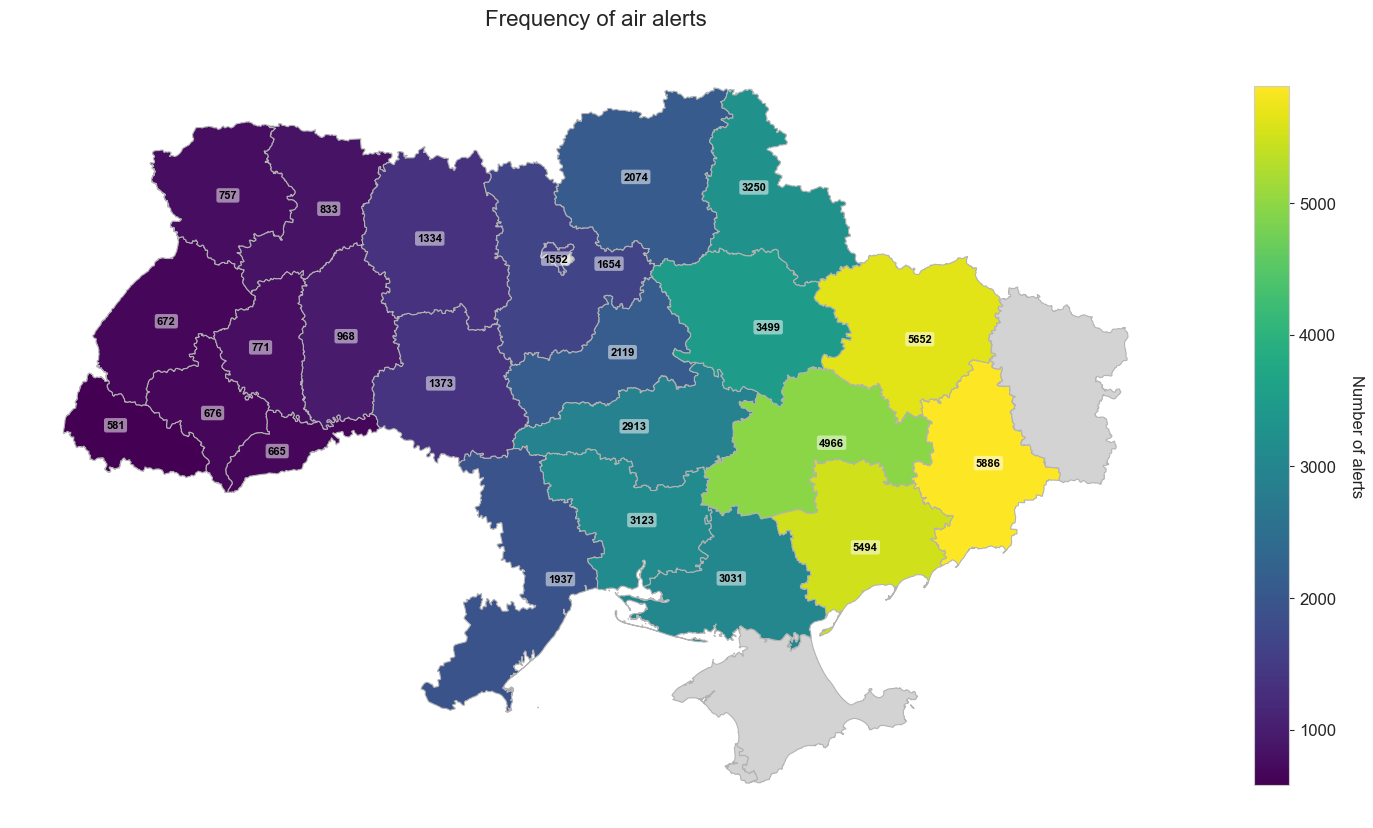

In [119]:
alert_counts_per_region = df.groupby('region_city').size()
alert_counts_df = alert_counts_per_region.reset_index(name='alert_count')

gdf = gpd.read_file("gadm41_UKR_1.json")

gdf['region_name_ukr'] = gdf['NAME_1'].map(ukrainian_name_mapping)

merged_gdf = gdf.merge(alert_counts_df, how='left', left_on='region_name_ukr', right_on='region_city')

cmap = plt.cm.viridis
vmin = alert_counts_df['alert_count'].min()
vmax = alert_counts_df['alert_count'].max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

merged_gdf.plot(
    column='alert_count',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.7',
    missing_kwds={'color': 'lightgrey'}
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Number of alerts', rotation=270, labelpad=20, fontsize=12)

ax.set_title('Frequency of air alerts', fontsize=16, pad=20)
ax.set_axis_off()

for idx, row in merged_gdf.iterrows():
    if pd.notna(row['alert_count']) and row['geometry'].is_valid:
        point = row['geometry'].representative_point()
        ax.text(
            point.x, point.y,
            f"{int(row['alert_count'])}",
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            weight='bold',
            color='black',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5, ec='none')
             )
plt.tight_layout()
pdf.savefig()
plt.show()

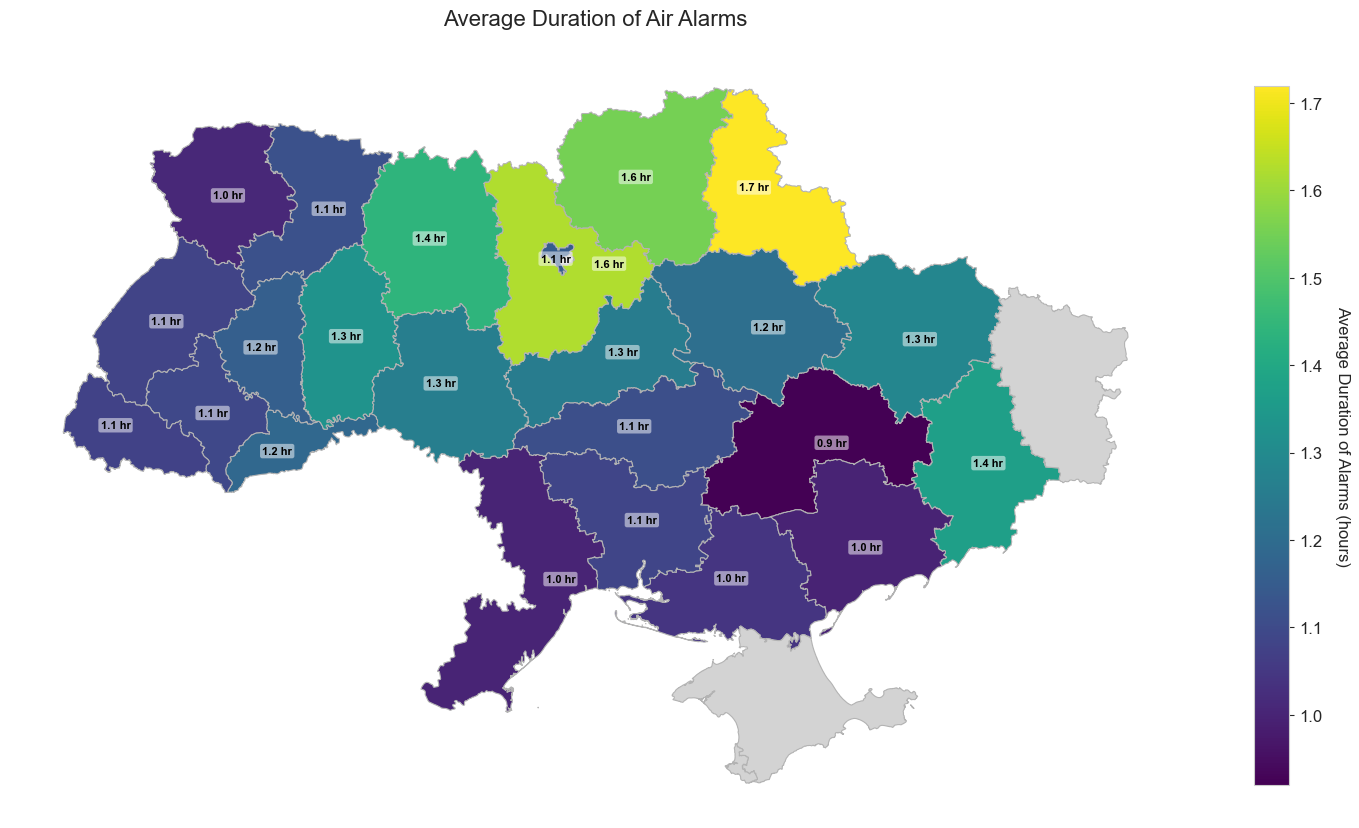

In [120]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])

df['duration'] = (df['end'] - df['start']).dt.total_seconds() / 3600

avg_duration_per_region = df.groupby('region_city')['duration'].mean().reset_index(name='avg_duration')

gdf = gpd.read_file("gadm41_UKR_1.json")

gdf['region_name_ukr'] = gdf['NAME_1'].map(ukrainian_name_mapping)

merged_gdf = gdf.merge(avg_duration_per_region, how='left', left_on='region_name_ukr', right_on='region_city')

cmap = plt.cm.viridis
vmin = merged_gdf['avg_duration'].min()
vmax = merged_gdf['avg_duration'].max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

merged_gdf.plot(
    column='avg_duration',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.7',
    missing_kwds={'color': 'lightgrey'}
)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)
cbar.set_label('Average Duration of Alarms (hours)', rotation=270, labelpad=20, fontsize=12)

ax.set_title('Average Duration of Air Alarms', fontsize=16, pad=20)
ax.set_axis_off()

for idx, row in merged_gdf.iterrows():
    if pd.notna(row['avg_duration']) and row['geometry'].is_valid:
        point = row['geometry'].representative_point()
        text = f"{row['avg_duration']:.1f} hr"
        ax.text(
            point.x, point.y,
            text,
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=8,
            weight='bold',
            color='black',
            bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.5, ec='none')
        )

plt.tight_layout()
pdf.savefig()
plt.show()

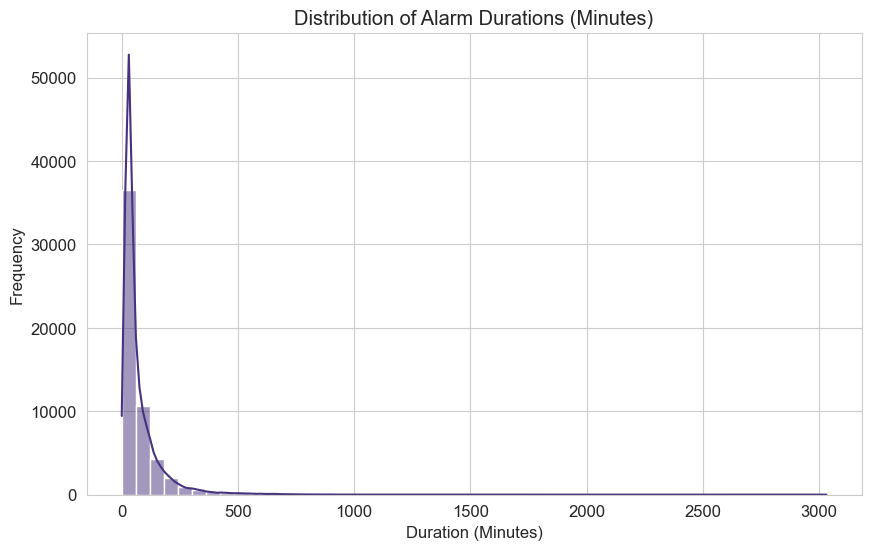

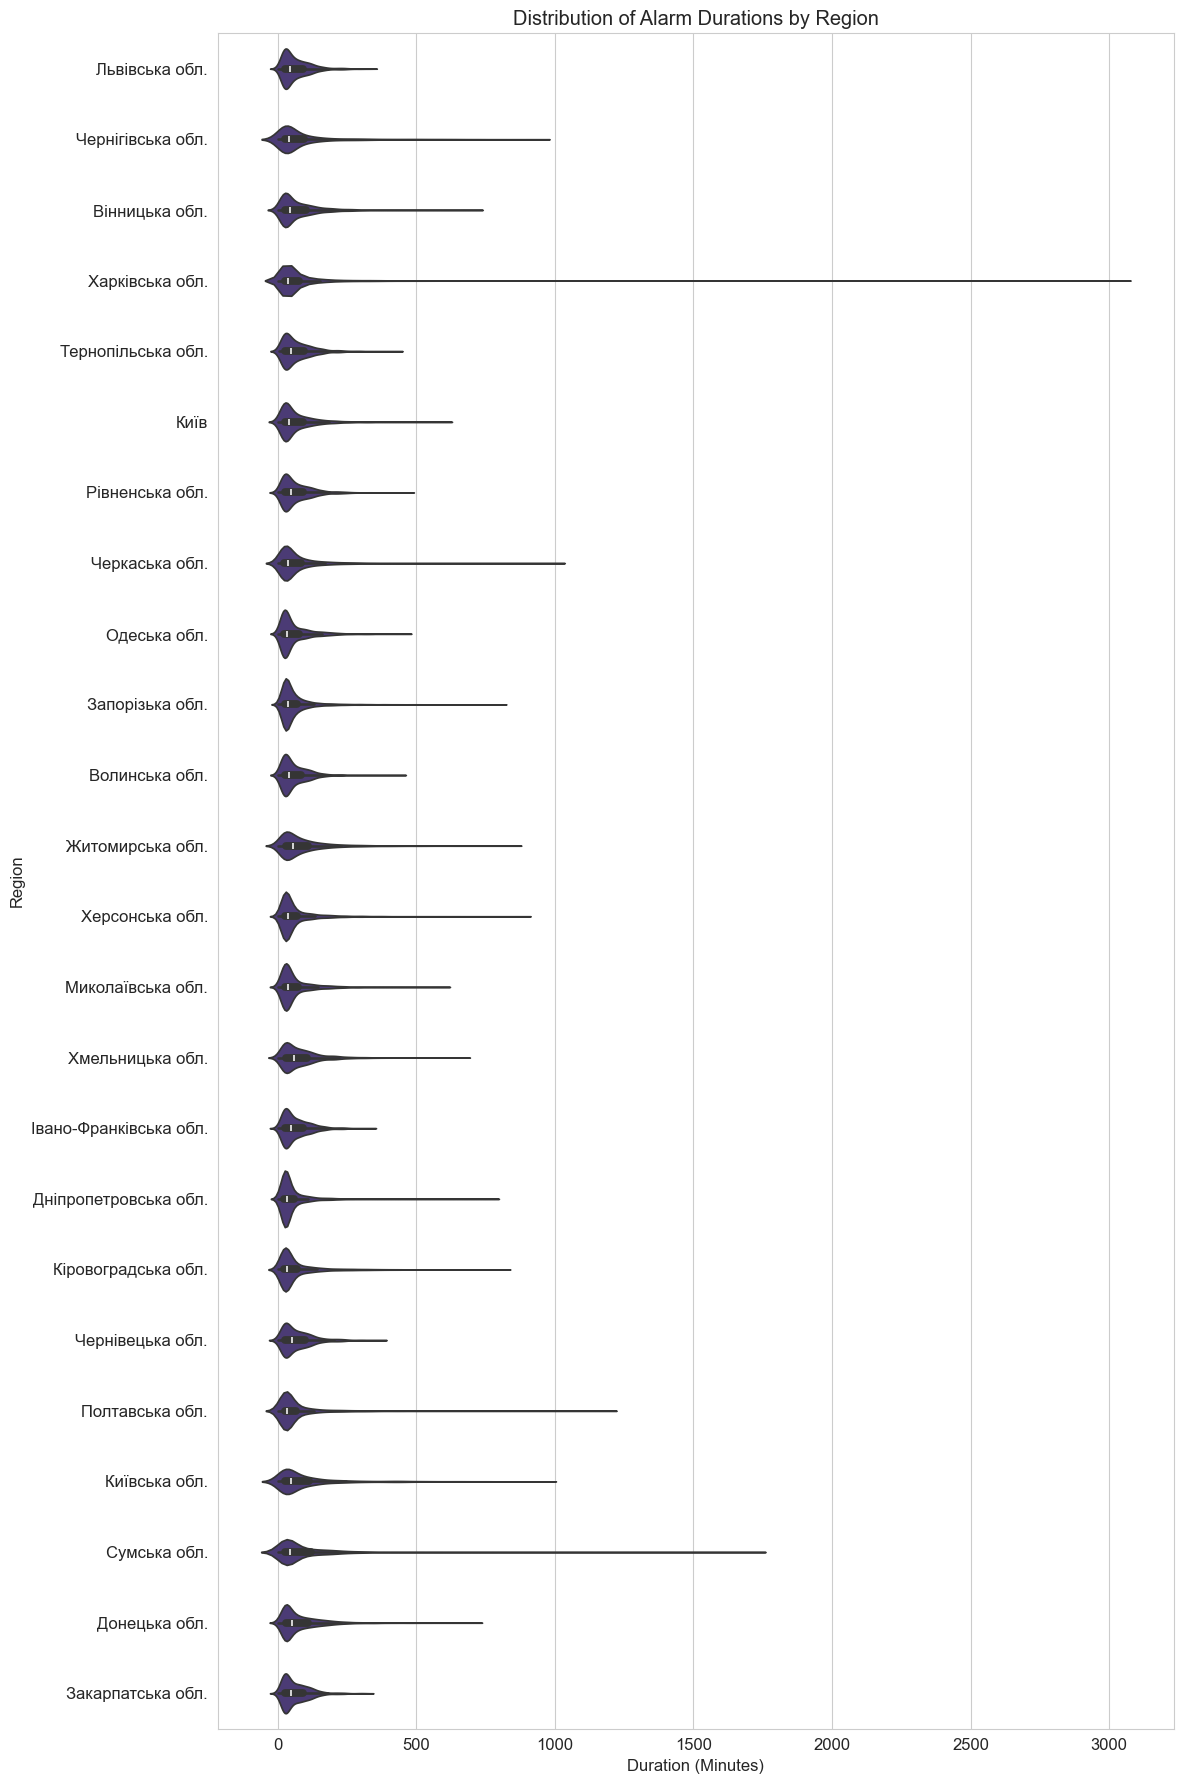

In [121]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration_minutes'], bins=50, kde=True)
plt.title('Distribution of Alarm Durations (Minutes)')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Frequency')
pdf.savefig()
plt.show()

plt.figure(figsize=(12, 18))
sns.violinplot(data=df, y='region_city', x='duration_minutes', orient='h')
plt.title('Distribution of Alarm Durations by Region')
plt.xlabel('Duration (Minutes)')
plt.ylabel('Region')
plt.tight_layout()
pdf.savefig()
plt.show()

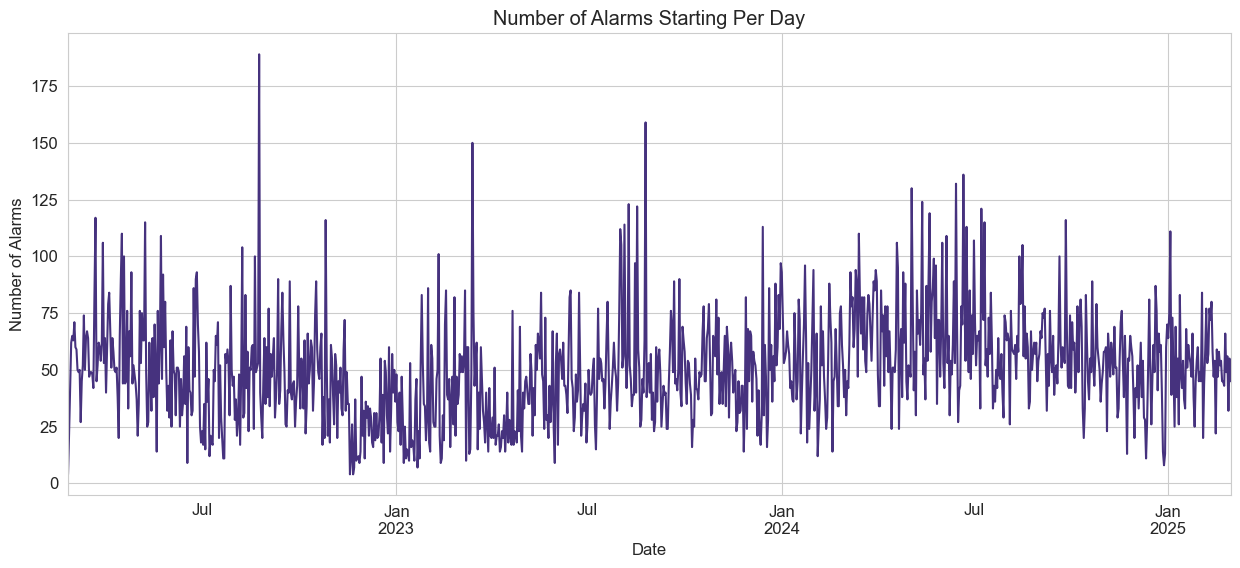

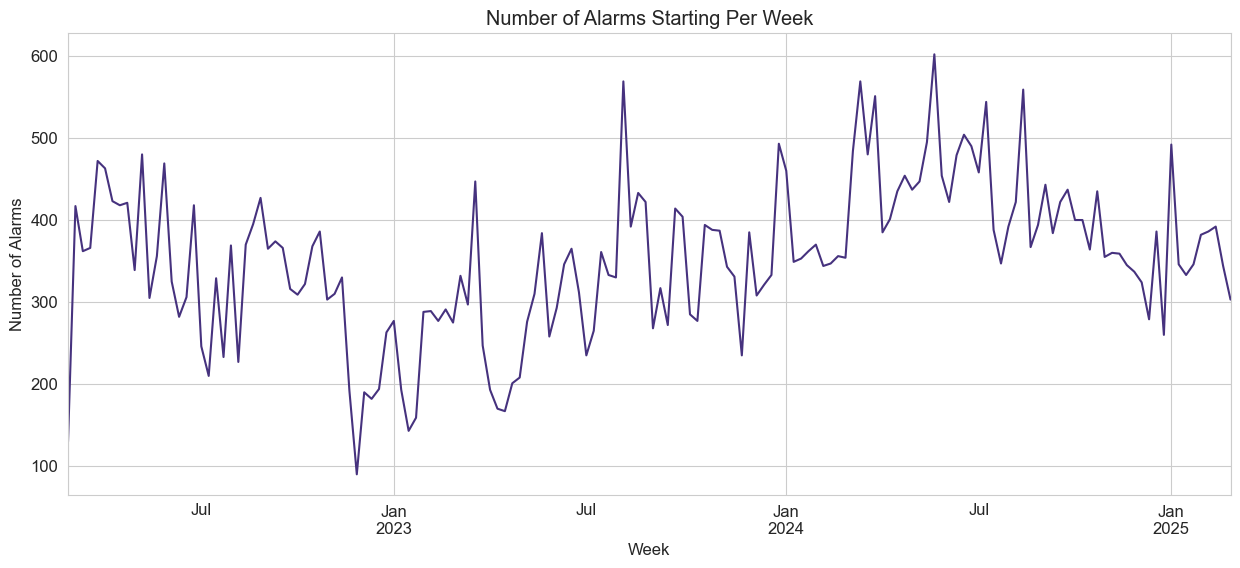

In [122]:
alarms_per_day.plot(figsize=(15, 6), title='Number of Alarms Starting Per Day')
plt.ylabel('Number of Alarms')
plt.xlabel('Date')
plt.grid(True)
pdf.savefig()
plt.show()

# Or resample weekly/monthly for smoother trends
alarms_per_week = df.set_index('start').resample('W').size()
alarms_per_week.plot(figsize=(15, 6), title='Number of Alarms Starting Per Week')
plt.ylabel('Number of Alarms')
plt.xlabel('Week')
plt.grid(True)
pdf.savefig()
plt.show()

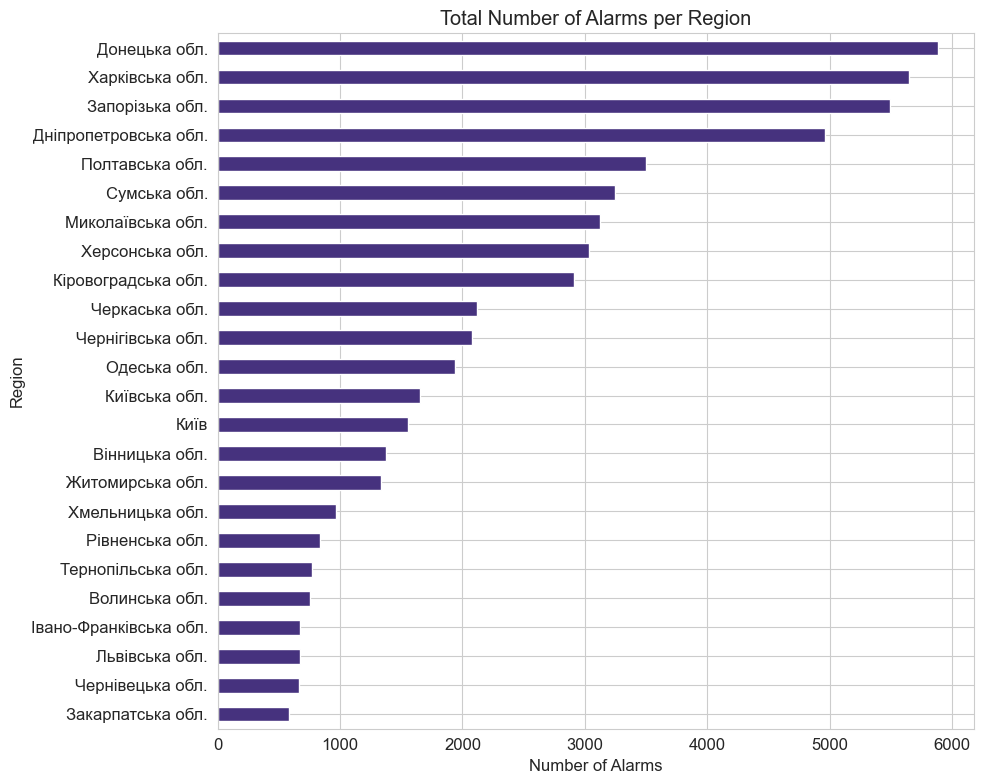

In [123]:
plt.figure(figsize=(10, 8))
alarms_per_region.sort_values().plot(kind='barh')
plt.title('Total Number of Alarms per Region')
plt.xlabel('Number of Alarms')
plt.ylabel('Region')
plt.tight_layout()
pdf.savefig()
plt.show()

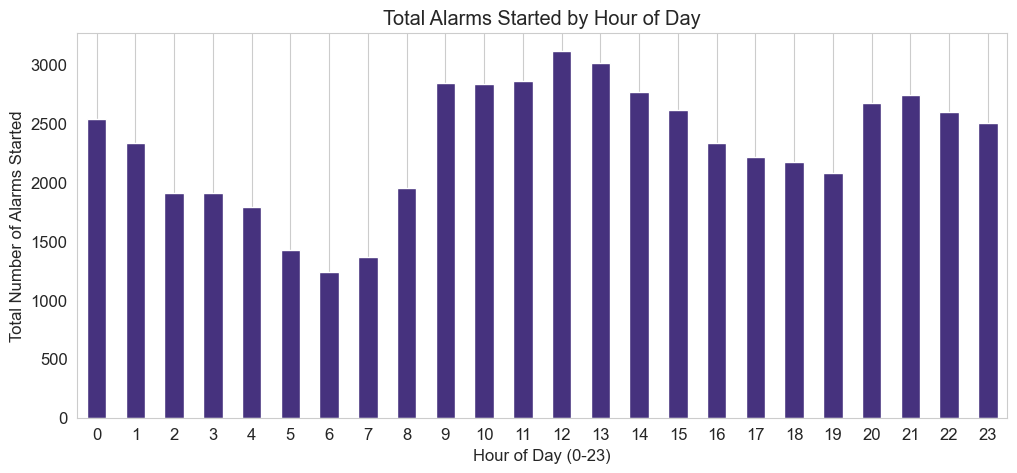

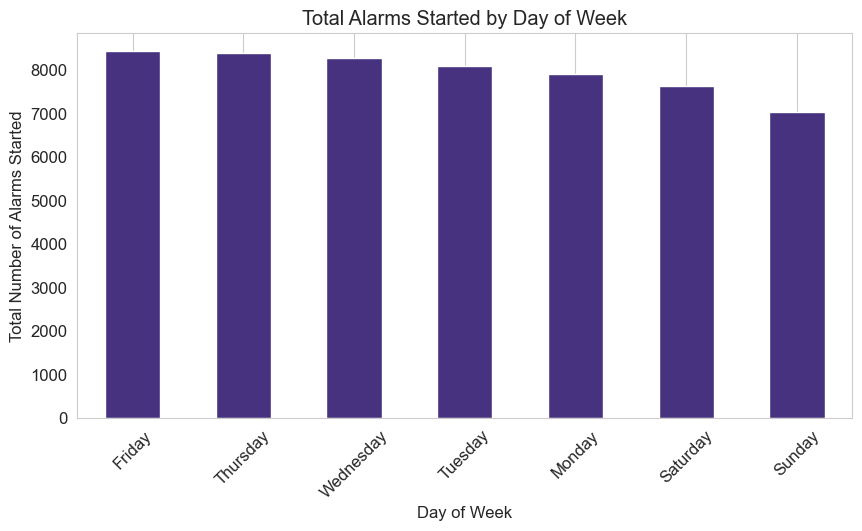

In [124]:
start_hour_counts = df['start'].dt.hour.value_counts().sort_index()
plt.figure(figsize=(12, 5))
start_hour_counts.plot(kind='bar')
plt.title('Total Alarms Started by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Total Number of Alarms Started')
plt.xticks(rotation=0)
plt.grid(axis='y')
pdf.savefig()
plt.show()


start_dow_counts = df['start'].dt.day_name().value_counts()
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
start_dow_counts.plot(kind='bar')
plt.title('Total Alarms Started by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Number of Alarms Started')
plt.xticks(rotation=45)
plt.grid(axis='y')
pdf.savefig()
plt.show()

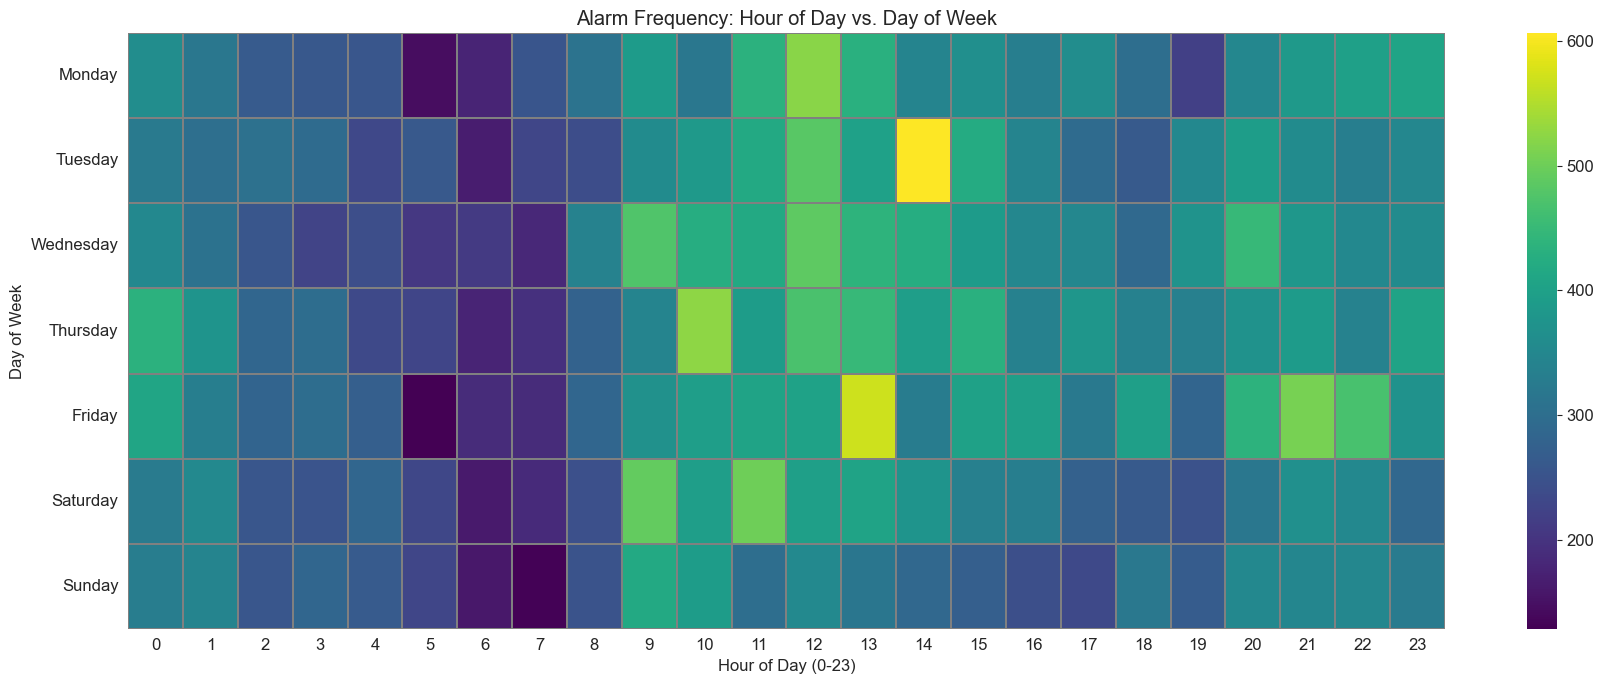

In [125]:
df['hour_of_day'] = df['start'].dt.hour
df['day_of_week'] = df['start'].dt.dayofweek # Monday=0, Sunday=6

pivot_table = pd.pivot_table(
    df,
    index='day_of_week',
    columns='hour_of_day',
    aggfunc='size',
    fill_value=0
)
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(18, 7))
ax = sns.heatmap(pivot_table, cmap='viridis', linecolor='grey', linewidths=0.1)
plt.title('Alarm Frequency: Hour of Day vs. Day of Week')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Day of Week')
yticks = ax.get_yticks()
ax.set_yticklabels(day_names, rotation=0, va='center')
plt.tight_layout()
pdf.savefig()
plt.show()

In [126]:
# 4. BASIC ANALYSIS AND VISUALIZATION OF THE DERIVED DATA

In [127]:
# 1. data validation
# 1.1. index check
min_timestamp = hourly_alarm_data.index.get_level_values('hour_start').min()
max_timestamp = hourly_alarm_data.index.get_level_values('hour_start').max()
print(f"\nTime range in index: {min_timestamp} to {max_timestamp}")

num_regions = hourly_alarm_data.index.get_level_values('region_city').nunique()
total_hours = (max_timestamp - min_timestamp) / np.timedelta64(1, 'h') + 1
expected_rows = num_regions * total_hours
print(f"Number of unique regions: {num_regions}")
print(f"Total hours in range: {int(total_hours)}")
print(f"Expected rows: {int(expected_rows)}")
print(f"Actual rows in DataFrame: {len(hourly_alarm_data)}")
# if it is equal to 634752 it also means that we have correctly prepared this dataset for merging it with the weather dataset.

# 1.2. feature range check
min_val = hourly_alarm_data['alarm_minutes_in_hour'].min()
max_val = hourly_alarm_data['alarm_minutes_in_hour'].max()
print(f"alarm_minutes_in_hour range: [{min_val}, {max_val}] (Expected: [0, 60])")

unique_vals = hourly_alarm_data['is_alarm_active'].unique()
print(f"is_alarm_active unique values: {unique_vals} (Expected: [0, 1])")

min_val = hourly_alarm_data['alarms_started_in_hour'].min()
max_val = hourly_alarm_data['alarms_started_in_hour'].max()
print(f"alarms_started_in_hour range: [{min_val}, {max_val}] (Expected: >= 0)")

min_val = hourly_alarm_data['time_since_last_alarm_end_minutes'].min()
max_val = hourly_alarm_data['time_since_last_alarm_end_minutes'].max()
null_count = hourly_alarm_data['time_since_last_alarm_end_minutes'].isnull().sum()
print(f"time_since_last_alarm_end_minutes range (non-null): [{min_val:.2f}, {max_val:.2f}] (Expected: >= 0)")
print(f"Null count: {null_count}")
# probably near the upper bound of the data
# (upper bound is the date 2025-03-01 23:00:00, by which time alarms that started a bit earlier may not have completed)

# 1.3. сonsistency сhecks
inconsistent_zeros = hourly_alarm_data[(hourly_alarm_data['is_alarm_active'] == 0) & (hourly_alarm_data['alarm_minutes_in_hour'] != 0)].shape[0]
inconsistent_positives = hourly_alarm_data[(hourly_alarm_data['is_alarm_active'] == 1) & (hourly_alarm_data['alarm_minutes_in_hour'] <= 0)].shape[0]
print(f"Hours where is_alarm_active=0 but minutes>0: {inconsistent_zeros}")
print(f"Hours where is_alarm_active=1 but minutes<=0: {inconsistent_positives}")


Time range in index: 2022-02-24 00:00:00 to 2025-03-01 23:00:00
Number of unique regions: 24
Total hours in range: 26448
Expected rows: 634752
Actual rows in DataFrame: 634752
alarm_minutes_in_hour range: [0.0, 60.0] (Expected: [0, 60])
is_alarm_active unique values: [0 1] (Expected: [0, 1])
alarms_started_in_hour range: [0, 3] (Expected: >= 0)
time_since_last_alarm_end_minutes range (non-null): [0.00, 512149.35] (Expected: >= 0)
Null count: 0
Hours where is_alarm_active=0 but minutes>0: 0
Hours where is_alarm_active=1 but minutes<=0: 0


In [128]:
# 2. overall statistics
numeric_cols = hourly_alarm_data.select_dtypes(include=np.number).columns
print(hourly_alarm_data[numeric_cols].describe())

overall_alarm_prob = hourly_alarm_data['is_alarm_active'].mean()
print(f"Overall probability of an hour having an active alarm: {overall_alarm_prob:.4f}")

avg_minutes_when_active = hourly_alarm_data[hourly_alarm_data['is_alarm_active'] == 1]['alarm_minutes_in_hour'].mean()
print(f"Average alarm minutes per hour (when active): {avg_minutes_when_active:.2f}")

non_null_time_since = hourly_alarm_data['time_since_last_alarm_end_minutes'].dropna()
avg_time_since_last = non_null_time_since.mean()
median_time_since_last = non_null_time_since.median()
print(f"Average time since last alarm end (minutes): {avg_time_since_last:.2f}")
print(f"Median time since last alarm end (minutes): {median_time_since_last:.2f}")

       alarm_minutes_in_hour  is_alarm_active  alarms_started_in_hour  \
count          634752.000000    634752.000000           634752.000000   
mean                6.394056         0.185268                0.087877   
std                15.952916         0.388515                0.290043   
min                 0.000000         0.000000                0.000000   
25%                 0.000000         0.000000                0.000000   
50%                 0.000000         0.000000                0.000000   
75%                 0.000000         0.000000                0.000000   
max                60.000000         1.000000                3.000000   

       time_since_last_alarm_end_minutes  
count                      634752.000000  
mean                         3633.935758  
std                         30644.281076  
min                             0.000000  
25%                           206.950000  
50%                           618.075000  
75%                          1744.650000 

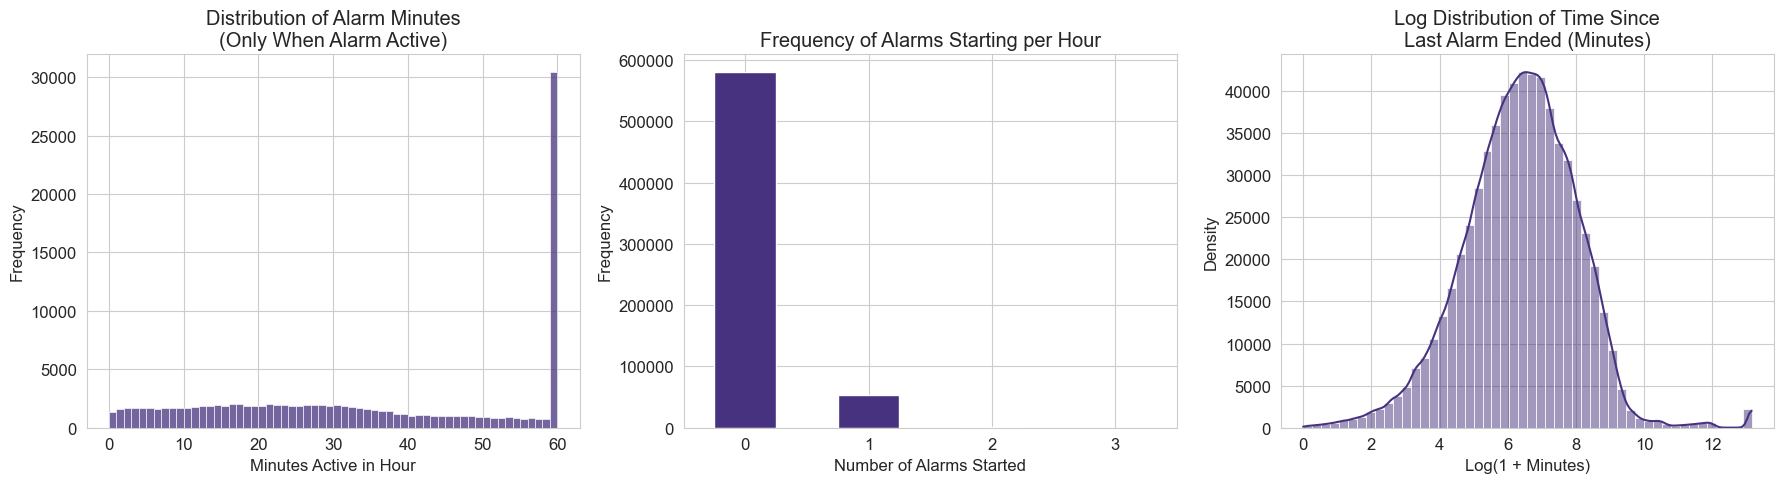

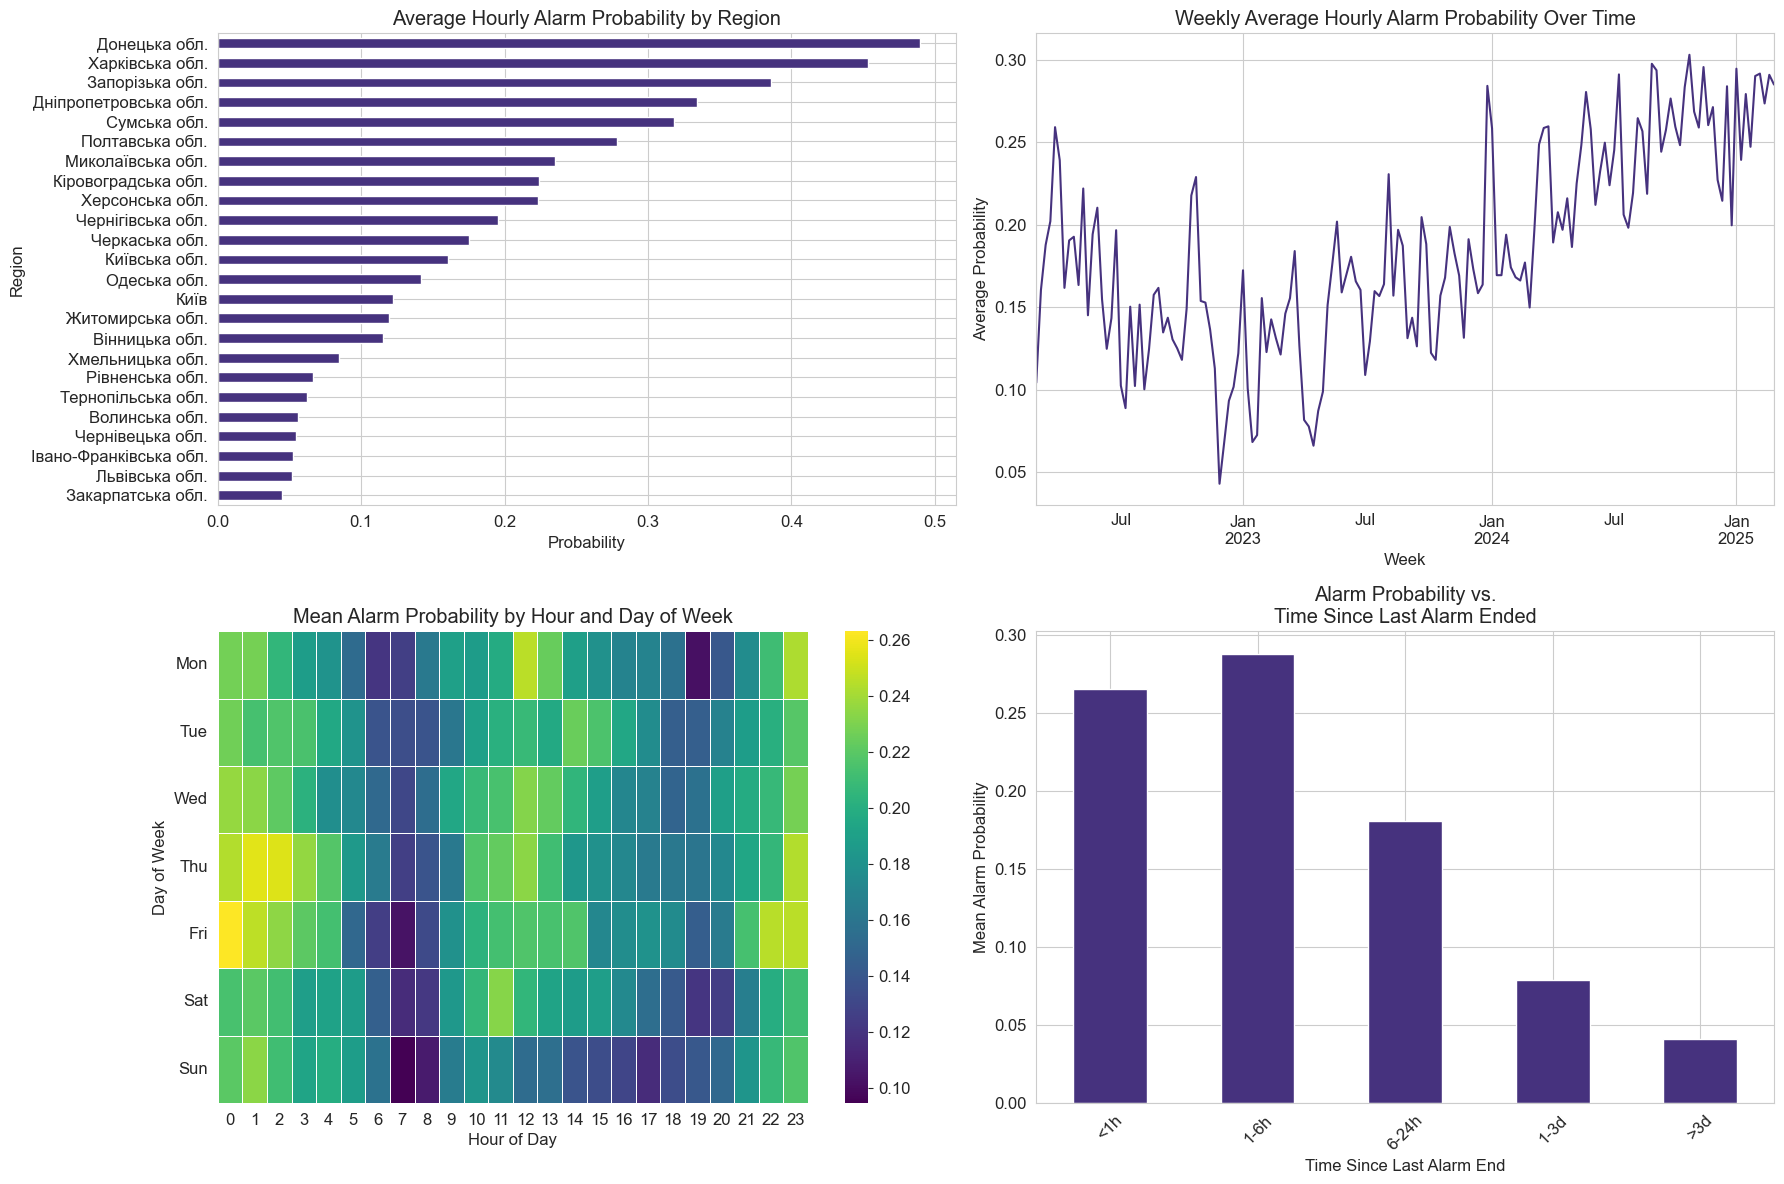

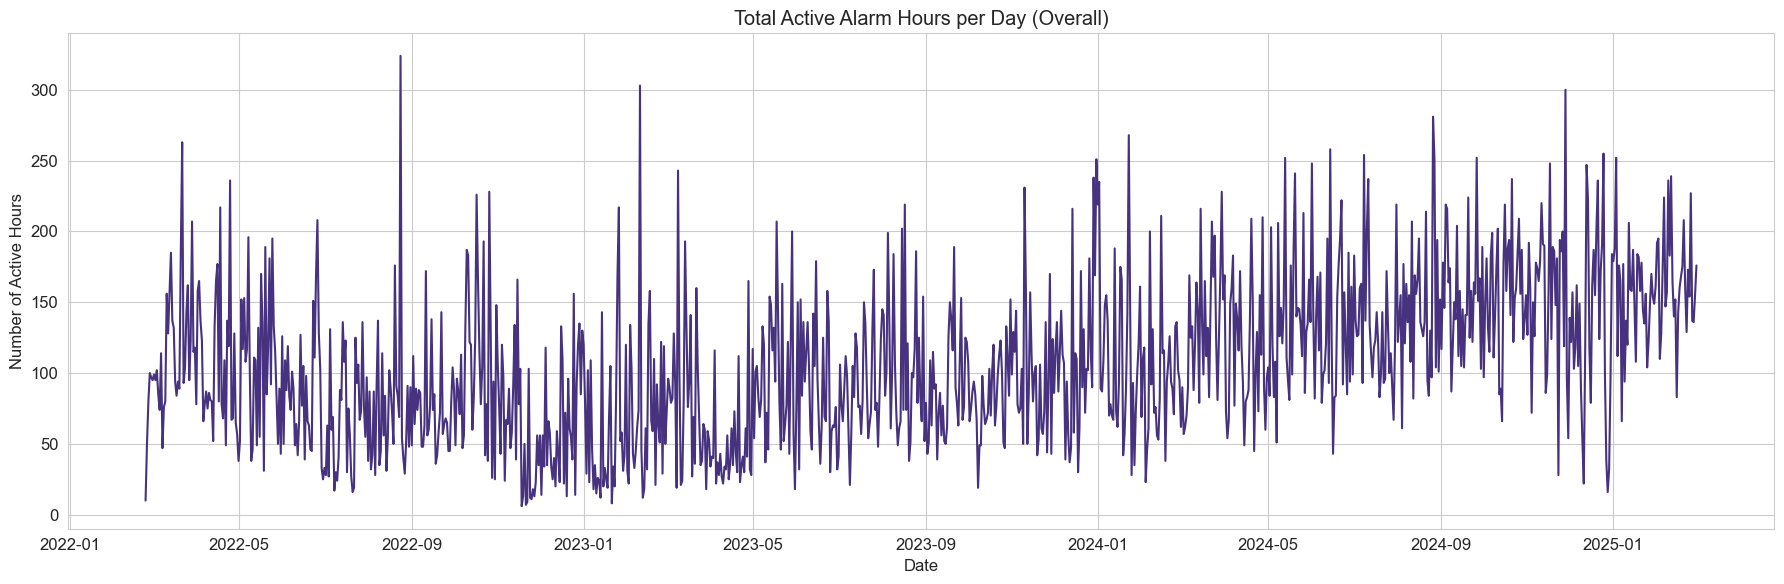

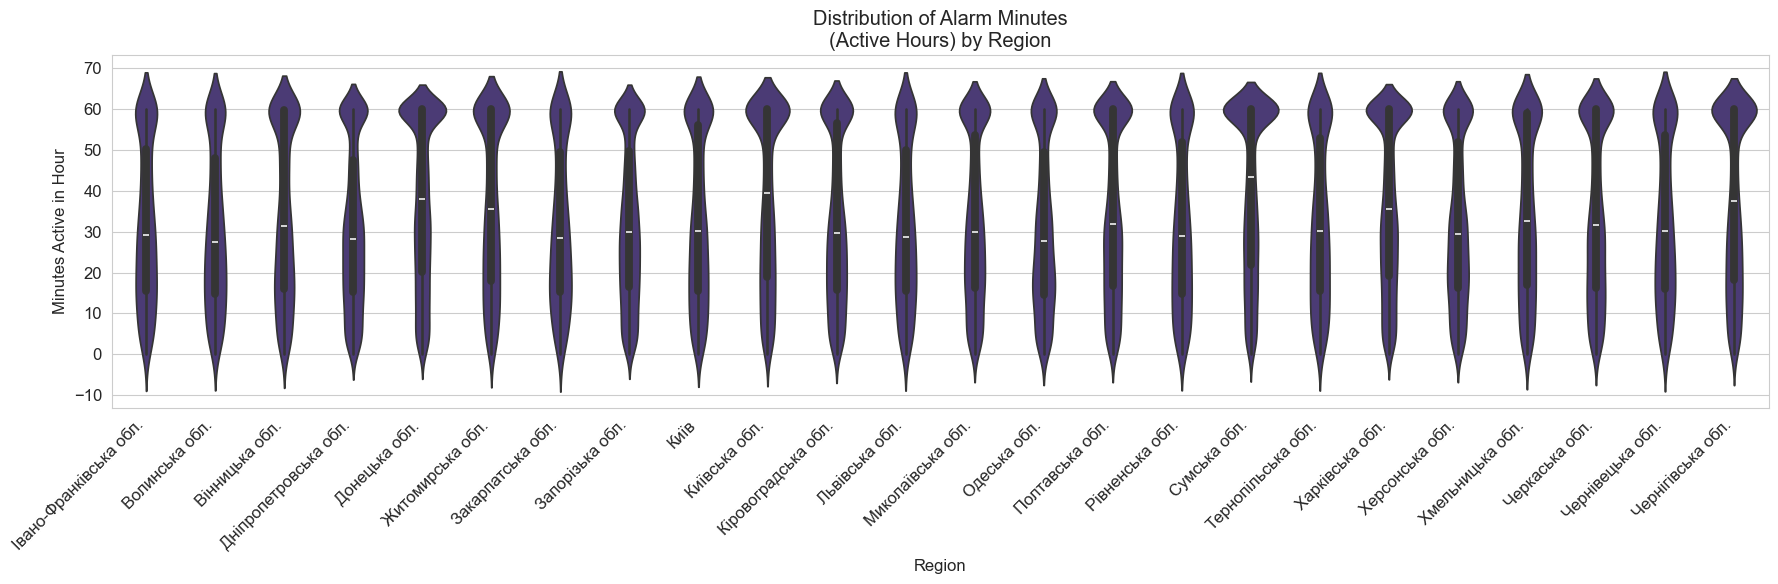

In [129]:
# 3. visualization
sns.set_palette("viridis")
hourly_alarm_data['hour'] = hourly_alarm_data.index.get_level_values('hour_start').hour
hourly_alarm_data['dayofweek'] = hourly_alarm_data.index.get_level_values('hour_start').dayofweek # Monday=0, Sunday=6
hourly_alarm_data['date'] = hourly_alarm_data.index.get_level_values('hour_start').date


# 3.1. distributions of individual features
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(hourly_alarm_data[hourly_alarm_data['is_alarm_active'] == 1]['alarm_minutes_in_hour'], bins=60, kde=False)
plt.title('Distribution of Alarm Minutes\n(Only When Alarm Active)')
plt.xlabel('Minutes Active in Hour')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
start_counts = hourly_alarm_data['alarms_started_in_hour'].value_counts().sort_index()
start_counts.plot(kind='bar')
plt.title('Frequency of Alarms Starting per Hour')
plt.xlabel('Number of Alarms Started')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

plt.subplot(1, 3, 3)
# otherwise not perceptible at all (looks like log)
sns.histplot(np.log1p(hourly_alarm_data['time_since_last_alarm_end_minutes'].dropna()), bins=50, kde=True)
plt.title('Log Distribution of Time Since\nLast Alarm Ended (Minutes)')
plt.xlabel('Log(1 + Minutes)')
plt.ylabel('Density')

plt.tight_layout()
pdf.savefig()
plt.show()


# 3.2. 'is_alarm_active' patterns
plt.figure(figsize=(18, 12))

# by region
plt.subplot(2, 2, 1)
prob_by_region = hourly_alarm_data.groupby(level='region_city')['is_alarm_active'].mean().sort_values()
prob_by_region.plot(kind='barh')
plt.title('Average Hourly Alarm Probability by Region')
plt.xlabel('Probability')
plt.ylabel('Region')

# weekly aggregation
plt.subplot(2, 2, 2)
prob_over_time = hourly_alarm_data.groupby(level='hour_start')['is_alarm_active'].mean().resample('W').mean()
prob_over_time.plot()
plt.title('Weekly Average Hourly Alarm Probability Over Time')
plt.xlabel('Week')
plt.ylabel('Average Probability')

# by time of day / day of week heatmap
plt.subplot(2, 2, 3)
pivot = hourly_alarm_data.pivot_table(values='is_alarm_active', index='dayofweek', columns='hour', aggfunc='mean')
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sns.heatmap(pivot, cmap='viridis', annot=False, fmt=".2f", linewidths=.5, yticklabels=day_names)
plt.title('Mean Alarm Probability by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(rotation=0)

# 'time_since_last_alarm_end_minutes' vs 'is_alarm_active'
plt.subplot(2, 2, 4)
bins = [-1, 60, 360, 1440, 1440*3, np.inf] # Up to 1hr, 6hr, 1day, 3 days, >3 days
labels = ['<1h', '1-6h', '6-24h', '1-3d', '>3d']
hourly_alarm_data_temp = hourly_alarm_data.copy()
hourly_alarm_data_temp['time_since_last_alarm_end_minutes'] = hourly_alarm_data_temp['time_since_last_alarm_end_minutes'].fillna(np.inf) # nulls as infinite time passed
hourly_alarm_data_temp['time_since_bin'] = pd.cut(hourly_alarm_data_temp['time_since_last_alarm_end_minutes'], bins=bins, labels=labels, right=False)

binned_prob = hourly_alarm_data_temp.groupby('time_since_bin', observed=False)['is_alarm_active'].mean()
binned_prob.plot(kind='bar')
plt.title('Alarm Probability vs.\nTime Since Last Alarm Ended')
plt.xlabel('Time Since Last Alarm End')
plt.ylabel('Mean Alarm Probability')
plt.xticks(rotation=45)

plt.tight_layout()
pdf.savefig()
plt.show()


# 3.3. overall daily counts
plt.figure(figsize=(18, 6))
daily_alarms = hourly_alarm_data[hourly_alarm_data['is_alarm_active']==1].groupby('date').size()
daily_alarms.plot()
plt.title('Total Active Alarm Hours per Day (Overall)')
plt.xlabel('Date')
plt.ylabel('Number of Active Hours')
plt.tight_layout()
plt.show()


# 3.4. regional variations
plt.figure(figsize=(18, 6))
active_hours_df = hourly_alarm_data[hourly_alarm_data['is_alarm_active'] == 1].reset_index()
sns.violinplot(data=active_hours_df, x='region_city', y='alarm_minutes_in_hour')
plt.title('Distribution of Alarm Minutes\n(Active Hours) by Region')
plt.xlabel('Region')
plt.ylabel('Minutes Active in Hour')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
pdf.savefig()
plt.show()

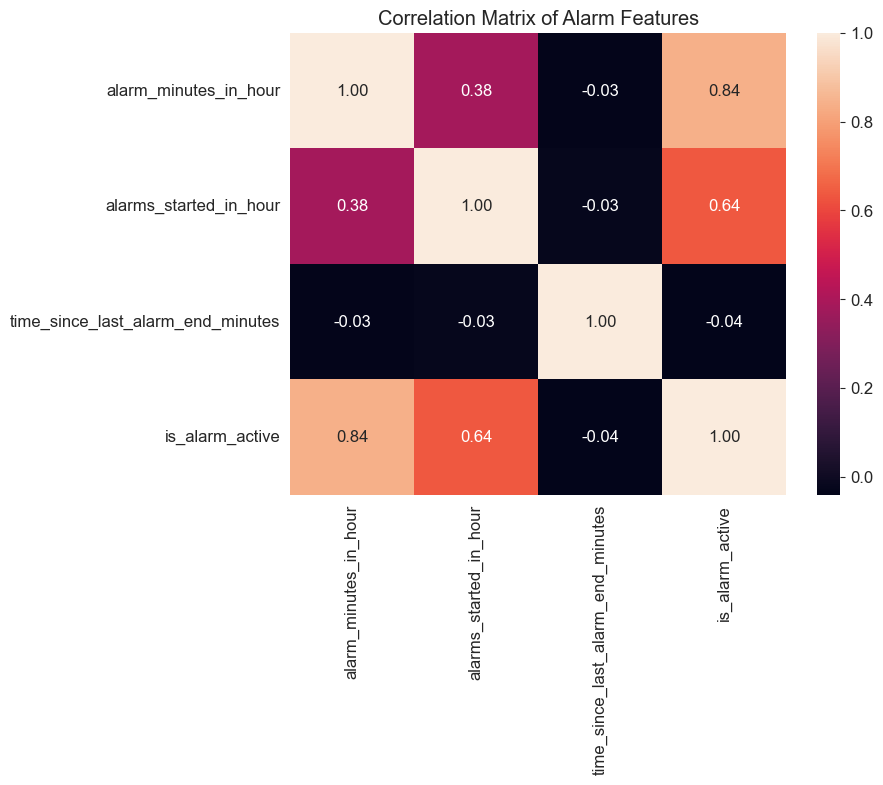

In [130]:
correlation_matrix = hourly_alarm_data[['alarm_minutes_in_hour', 'alarms_started_in_hour', 'time_since_last_alarm_end_minutes', 'is_alarm_active']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix of Alarm Features')
pdf.savefig()
plt.show()

In [131]:
pdf.close()